# **U - Net**

[CE477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Authors__: Kiarash Joolaei

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharifiZarchi/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/UNet.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/SharifiZarchi/Introduction_to_Machine_Learning/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/UNet.ipynb)

---

## Notebook Objectives
In this notebook we introduce the U - Net architecture and investigate its use cases in different tasks of computer vision.


## Transposed Convolution

To start things off we first get familiar with the transposed convolution operation.

**Transposed convolution**, also known as deconvolution, is a way **upsample** feature maps, often for tasks like image segmentation and generation. It essentially reverses the downsampling effect of a standard convolution.

In 2D manner, transposed convolution can be defined alongside convolution as below.


*   Convolution
$$
\text{output}[i, j] = \sum_{k=0}^{K-1} \sum_{l=0}^{L-1} \text{input}[i+k, j+l] \times \text{kernel}[k, l]
$$
*   Transposed Convolution
$$
\text{reconstructed  input}[i, j] = \sum_{k=0}^{K-1} \sum_{l=0}^{L-1} \text{output}[i-k, j-l] \times \text{kernel}[k, l]
$$

It can be seen that transposed convolution increases the dimensionality of the its input. As an example you can see and compare how convolution and transposed convolution below :



<div style="text-align:center;">
  <img src="Images/transposed.gif" style="width:600px; height:auto;" />
</div>

To be more precise, the output size can be calculated as :

$$O = S \times (I - 1) + K - 2P$$

where $O$ is the output size, $I$ is the input size, $K$ is the kernel size, and lastly $S$ and $P$ are stride and padding.

Now we will implement this operation and see its results on images. We first convolve and then transpose convolve a kernel to compare the output with input. Note that the output is not gonna be the input exactly but rather an unsampled embedding of it.

Input Map:
[[1 2 1 2]
 [3 4 3 4]
 [1 2 1 2]
 [3 4 3 4]]

Convolution Output:
[[ -1.   4.  -7.   8.]
 [ 14.  18.   6.  23.]
 [ -8.  -6. -18.   1.]
 [ 17.  22.  11.  26.]]

Transposed Convolution Output:
[[ -44.    2. -115.   42.]
 [ 105.  160.   25.  194.]
 [-129. -110. -245.  -40.]
 [ 128.  180.   63.  214.]]


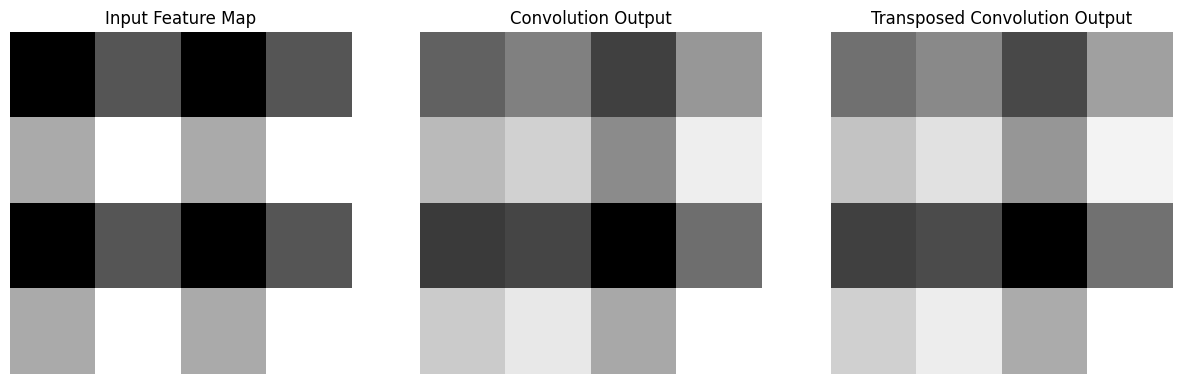

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Function to apply a 2D convolution
def convolution_2d(input, kernel, stride=1, padding=0):
    # Apply padding to the input
    if padding > 0:
        input = np.pad(input, ((padding, padding), (padding, padding)), mode='constant')

    # Calculate the output size
    input_height, input_width = input.shape
    kernel_size = kernel.shape[0]
    output_height = (input_height - kernel_size) // stride + 1
    output_width = (input_width - kernel_size) // stride + 1

    # Initialize output with zeros
    output = np.zeros((output_height, output_width))

    # Perform convolution operation
    for i in range(0, output_height):
        for j in range(0, output_width):
            # Extract the current region of interest
            current_region = input[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size]
            # Perform element-wise multiplication and sum the result
            output[i, j] = np.sum(current_region * kernel)

    return output

# Function to apply a 2D transposed convolution
def transposed_convolution_2d(input, kernel, stride=1, padding=0):
    # Upsample by inserting zeros between input elements
    upsampled_size = ((input.shape[0] - 1) * stride + 1, (input.shape[1] - 1) * stride + 1)
    upsampled = np.zeros(upsampled_size)
    upsampled[::stride, ::stride] = input  # Insert input values into upsampled array

    # Apply padding to the upsampled input
    if padding > 0:
        upsampled = np.pad(upsampled, ((padding, padding), (padding, padding)), mode='constant')

    # Calculate the output size
    upsampled_height, upsampled_width = upsampled.shape
    kernel_size = kernel.shape[0]
    output_height = upsampled_height - kernel_size + 1
    output_width = upsampled_width - kernel_size + 1

    # Initialize output with zeros
    output = np.zeros((output_height, output_width))

    # Perform convolution-like operation on the upsampled input
    for i in range(output_height):
        for j in range(output_width):
            # Perform element-wise multiplication and sum the result
            output[i, j] = np.sum(upsampled[i:i+kernel_size, j:j+kernel_size] * kernel)

    return output

# Example kernel (3x3)
kernel = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])

# Input feature map (for simplicity, let's use a 4x4 input)
input_map = np.array([[1, 2, 1, 2],
                      [3, 4, 3, 4],
                      [1, 2, 1, 2],
                      [3, 4, 3, 4]])

# Apply the convolution
conv_output = convolution_2d(input_map, kernel, stride=1, padding=1)

# Apply the transposed convolution to the convolution output
trans_conv_output = transposed_convolution_2d(conv_output, kernel, stride=1, padding=1)

print("Input Map:")
print(input_map)
print("\nConvolution Output:")
print(conv_output)
print("\nTransposed Convolution Output:")
print(trans_conv_output)

# Visualize the input and outputs
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_map, cmap='gray')
plt.title('Input Feature Map')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(conv_output, cmap='gray')
plt.title('Convolution Output')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(trans_conv_output, cmap='gray')
plt.title('Transposed Convolution Output')
plt.axis('off')

plt.show()


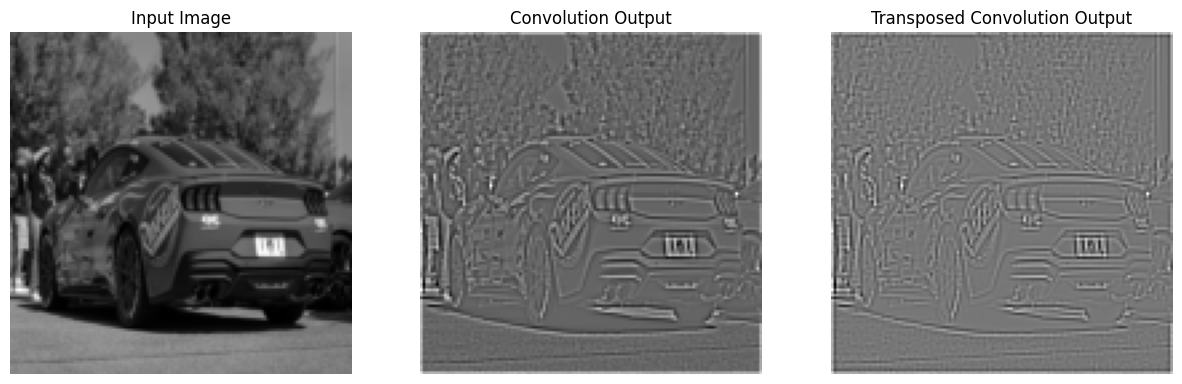

In [ ]:
# Function to preprocess an image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Load as grayscale
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))])
    return transform(img).squeeze(0).numpy()  # Remove batch dimension for simplicity

# Function to visualize input and output images
def visualize_images(input_image, conv_output, trans_conv_output):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image.squeeze(), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    # Convolution Output
    plt.subplot(1, 3, 2)
    plt.imshow(conv_output, cmap='gray')
    plt.title('Convolution Output')
    plt.axis('off')

    # Transposed Convolution Output
    plt.subplot(1, 3, 3)
    plt.imshow(trans_conv_output, cmap='gray')
    plt.title('Transposed Convolution Output')
    plt.axis('off')

    plt.show()

# Load and preprocess the image
input_image = preprocess_image('image.jpg')


# Apply the transposed convolution to the image
output_conv = convolution_2d(input_image, kernel, stride=1, padding=1)
output_image = transposed_convolution_2d(output_conv, kernel, stride=1, padding=1)
# Visualize the results
visualize_images(input_image, output_conv, output_image)


We can check the results with existing `torch.nn` modules.

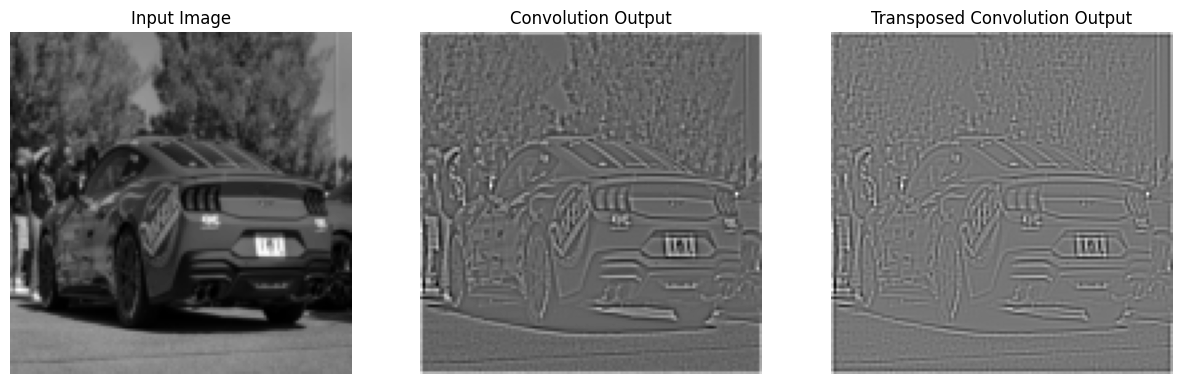

In [ ]:


# Load and preprocess an image
def load_image(image_path):
    img = Image.open(image_path).convert('L')  # Load as grayscale
    transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
    input_image = transform(img).unsqueeze(0)  # Add batch dimension
    return input_image

# Visualize the input, convolution output, and transposed convolution output
def visualize_results(input_image, conv_output, trans_conv_output):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image.squeeze(), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    # Convolution Output
    plt.subplot(1, 3, 2)
    plt.imshow(conv_output.detach().squeeze(), cmap='gray')
    plt.title('Convolution Output')
    plt.axis('off')

    # Transposed Convolution Output
    plt.subplot(1, 3, 3)
    plt.imshow(trans_conv_output.detach().squeeze(), cmap='gray')
    plt.title('Transposed Convolution Output')
    plt.axis('off')

    plt.show()

# Define a convolution layer with a 3x3 kernel
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)

edge_detection_kernel = torch.tensor([[[[-1, -1, -1],
                                        [-1,  8, -1],
                                        [-1, -1, -1]]]], dtype=torch.float32)

conv.weight.data = edge_detection_kernel

input_image = load_image('image.jpg')

# Apply the first convolution
conv_output = conv(input_image)

# Define a transposed convolution layer (using the same kernel size and padding)
conv_transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
conv_transpose.weight.data = edge_detection_kernel

# Apply the transposed convolution to the result of the first convolution
trans_conv_output = conv_transpose(conv_output)

visualize_results(input_image, conv_output, trans_conv_output)





## U - Net Implementation

In this section, we're going to first implement the structure of U - Net and then use it in a segmentation task on Oxford Pets III dataset.

One of the most popular usages of U - Nets is semantic segmentation in which we try to segment different pixels of an image and put the pixels with synonymous semantics in similar segments.

Oxford Pets III dataset is designed solely for the purpose of segmenting the existing pet in each photo.
This dataset is a simple and understandable candidate for a segmentation task that can be solved using U - Net.

<div style="text-align:center;">
  <img src="Images/segment.jpg" style="width:700px; height:auto;" />
</div>


### Dataset Download

Let's download the dataset from kaggle. Importing **Kaggle API Token** is essential.

In [ ]:
# Create the directory where the Kaggle API expects the file
!mkdir -p /root/.kaggle

from google.colab import files
files.upload()
# Move the kaggle.json file to the correct directory
!mv kaggle.json /root/.kaggle/

# Set permissions for the API token file
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d julinmaloof/the-oxfordiiit-pet-dataset

# Unzip the dataset
!unzip the-oxfordiiit-pet-dataset.zip -d oxford_pets

Streaming output truncated to the last 5000 lines.
  inflating: oxford_pets/images/Sphynx_9.jpg  
  inflating: oxford_pets/images/Sphynx_90.jpg  
  inflating: oxford_pets/images/Sphynx_91.jpg  
  inflating: oxford_pets/images/Sphynx_92.jpg  
  inflating: oxford_pets/images/Sphynx_93.jpg  
  inflating: oxford_pets/images/Sphynx_94.jpg  
  inflating: oxford_pets/images/Sphynx_95.jpg  
  inflating: oxford_pets/images/Sphynx_96.jpg  
  inflating: oxford_pets/images/Sphynx_98.jpg  
  inflating: oxford_pets/images/Sphynx_99.jpg  
  inflating: oxford_pets/images/american_bulldog_10.jpg  
  inflating: oxford_pets/images/american_bulldog_100.jpg  
  inflating: oxford_pets/images/american_bulldog_101.jpg  
  inflating: oxford_pets/images/american_bulldog_102.jpg  
  inflating: oxford_pets/images/american_bulldog_103.jpg  
  inflating: oxford_pets/images/american_bulldog_104.jpg  
  inflating: oxford_pets/images/american_bulldog_105.jpg  
  inflating: oxford_pets/images/american_bulldog_106.jpg  

### Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import numpy as np
from torch.utils.data import Dataset,DataLoader,SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt

### U-Net Architecture

U-Net is a convolutional neural network architecture designed primarily for image segmentation tasks. The architecture consists of two main parts: a contracting **encoder** path and an expansive **decoder** path.


The encoder captures context and reduces spatial dimensions through convolution and pooling layers, while the decoder upsamples the features to recover spatial resolution, enabling precise localization.


A key feature of U-Net is the use of skip connections, which directly transfer feature maps from the encoder to the corresponding layers in the decoder, helping to preserve detailed spatial information and improve segmentation accuracy. This makes U-Net especially effective for medical imaging and other applications requiring high-resolution segmentation.

<div style="text-align:center;">
  <img src="./Images/u-net-architecture.png" style="width:700px; height:auto;" />
</div>

In [ ]:

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.decoder1(d1)

        out = self.output_layer(d1)
        return torch.sigmoid(out)


### Dataset Configuration

In this section the dataset is defined as a module inherited from `Dataset`.

The masks are mapped into binary classes **pet** and **background**.

In [ ]:
class OxfordPetsDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        # Initialize a list to hold valid images and masks
        self.valid_images = []
        self.valid_masks = []

        # Populate the lists with valid images and masks
        for filename in os.listdir(image_dir):
            if filename.endswith('.jpg'):
                img_path = os.path.join(image_dir, filename)
                mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.png'))

                # Attempt to read the image
                image = cv2.imread(img_path)
                if image is not None:  # Only add valid images
                    # Attempt to read the mask
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is not None:  # Only add valid masks
                        self.valid_images.append(img_path)
                        self.valid_masks.append(mask_path)

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_path = self.valid_images[idx]
        mask_path = self.valid_masks[idx]

        # Read the image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Convert trimap to binary mask (1: pet, 0: background)
        mask = np.where(mask == 3, 1, 0).astype('float32')

        # Apply transformations if provided
        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


In [ ]:

image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = OxfordPetsDataset(
    image_dir='oxford_pets/images',
    mask_dir='oxford_pets/annotations/trimaps',
    image_transform=image_transform,
    mask_transform=mask_transform
)

train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=8, sampler=test_sampler)


### Training Phase

Epoch 1/10, Loss: 0.2877
Epoch 2/10, Loss: 0.2301
Epoch 3/10, Loss: 0.2131
Epoch 4/10, Loss: 0.2010
Epoch 5/10, Loss: 0.1914
Epoch 6/10, Loss: 0.1821
Epoch 7/10, Loss: 0.1736
Epoch 8/10, Loss: 0.1667
Epoch 9/10, Loss: 0.1571


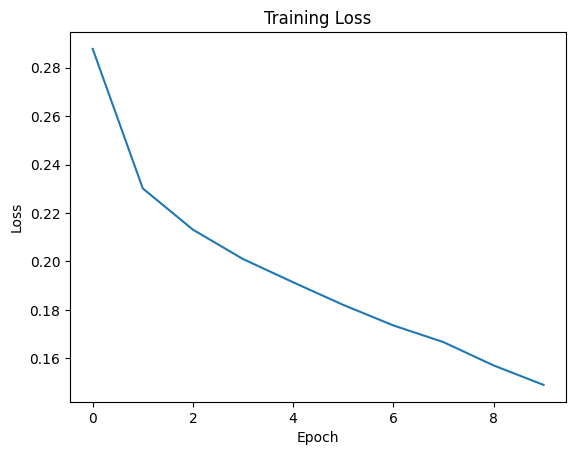

In [ ]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
train_loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)  # Add channel dimension to masks
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Plot training error
plt.plot(range(num_epochs), train_loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


### Evaluation Phase

Here the model is tested on a random sample from the test set. The model should be able to mask out the pet correctly.

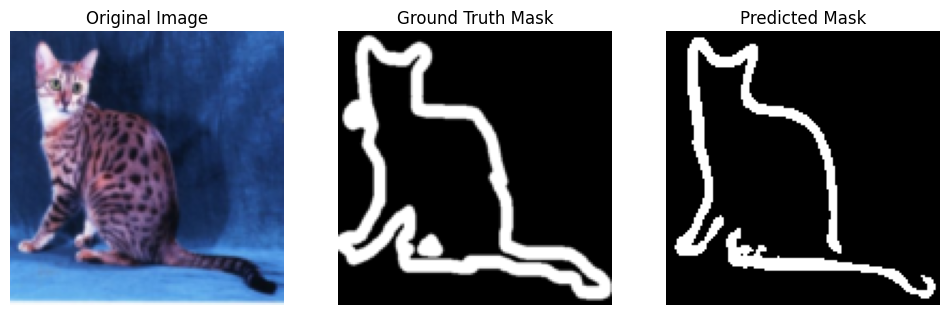

In [ ]:
def visualize_sample(model, test_loader, batch_num, idx):
    model.eval()

    # Get the specified batch of images and masks from the test loader
    for i, (images, masks) in enumerate(test_loader):
        if i == batch_num:
            break  # Stop when the desired batch is found

    # Select the image and mask at the specified index within the batch
    image = images[idx]
    mask = masks[idx].numpy()  # Convert mask to numpy for visualization

    # Move the image to the appropriate device (GPU or CPU)
    image = image.to(device)

    with torch.no_grad():
        # Make prediction
        pred_mask = model(image.unsqueeze(0)).cpu().numpy()  # Add batch dimension
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Squeeze the predicted mask to remove the channel dimension
    pred_mask = np.squeeze(pred_mask)  # Now shape will be (128, 128)
    mask = np.squeeze(mask)  # Ensure the ground truth mask is also (128, 128)

    # Display the images and masks
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(image.cpu().permute(1, 2, 0))  # Original Image
    ax[0].set_title('Original Image')
    ax[0].axis('off')  # Remove axis ticks and labels

    ax[1].imshow(mask, cmap='gray')  # Ground Truth Mask
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')  # Remove axis ticks and labels

    ax[2].imshow(pred_mask, cmap='gray')  # Predicted Mask
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')  # Remove axis ticks and labels

    plt.show()

# Visualize some results from a specific batch and index in the test set
visualize_sample(model, test_loader, batch_num=3, idx=2)


### Saving the Model

Saving the model parameters enables us to load the pre trained model whenever needed.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
model_save_path = '/content/drive/My Drive/unet_model.pth'

# Save the model
torch.save(model.state_dict(), model_save_path)
